# State preparation with the SLM mask

## Basics

When performing quantum computations with global pulses, it might be hard to prepare the system in an arbitrary initial state. This is especially true in the XY mode, where only a global $\sigma^x$ pulse can produce excitations whose number is otherwise conserved during free evolution. A partial solution to this problem is to utilize an SLM mask. <br>

Assume a system of three qubits in XY mode is initially in state $\left| 000 \right\rangle$, and that we are interested in preparing the state $\left| 100 \right\rangle$. Acting naively with a global $\sigma^x$ pulse of area $\pi$ would result in state $\left| 111 \right\rangle$. Using an SLM pattern, however, it is possible to detune the last two qubits away from resonance, and the same global $\sigma^x$ pulse will produced instead the desired state $\left| 100 \right\rangle$. <br>
Let's see how it works in practice. First create the register:

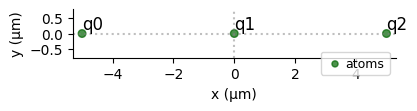

In [1]:
import numpy as np
from pulser import Pulse, Sequence, Register
from pulser.devices import MockDevice
from pulser.waveforms import BlackmanWaveform
from pulser_simulation import QutipEmulator

# Qubit register
qubits = {"q0": (-5, 0), "q1": (0, 0), "q2": (5, 0)}
reg = Register(qubits)
reg.draw()

## SLM Mask in XY mode

Let's now create the sequence and add a global $\sigma^x$ pulse of area $\pi$ in XY mode:

In [2]:
# Create the sequence
seq = Sequence(reg, MockDevice)

# Declare a global XY channel and add the pi pulse
seq.declare_channel("ch", "mw_global")
pulse = Pulse.ConstantDetuning(BlackmanWaveform(200, np.pi), 0, 0)
seq.add(pulse, "ch")

Drawing the sequence will show the following:

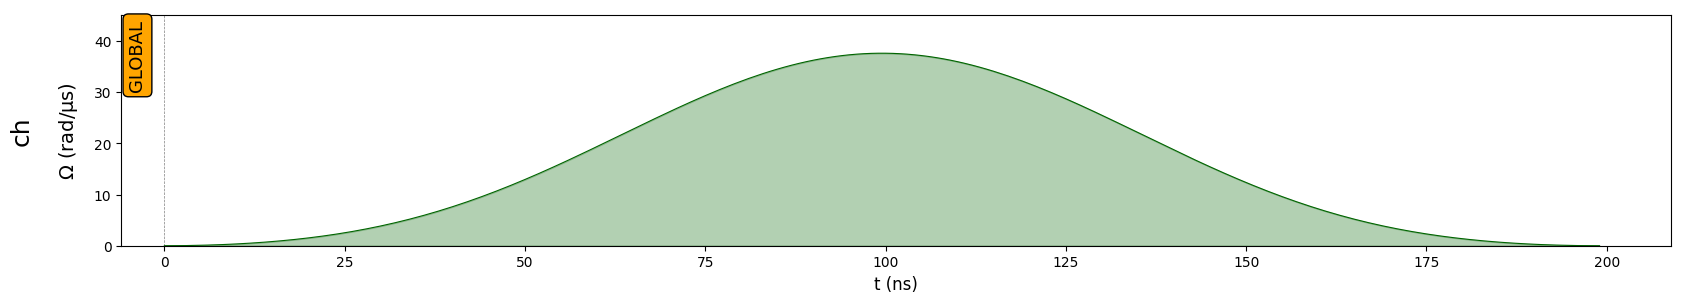

In [3]:
seq.draw()

To set up the SLM mask all we need to do is to pass to the $\verb:Sequence.config_slm_mask:$ method a list that contains the name of the qubits that we want to mask and the name of the `DMM` channel to use to configure the SLM Mask. The latter is taken as `dmm_0` by default. The device `MockDevice` contains one `DMM`, so `dmm_0` does indeed exist.

In [4]:
# Mask the last two qubits
masked_qubits = ["q1", "q2"]
seq.config_slm_mask(masked_qubits)

At this point it is possible to visualize the mask by drawing the sequence. The masked pulse will appear with a shaded background, and the names of the masked qubits will be shown in the bottom left corner.

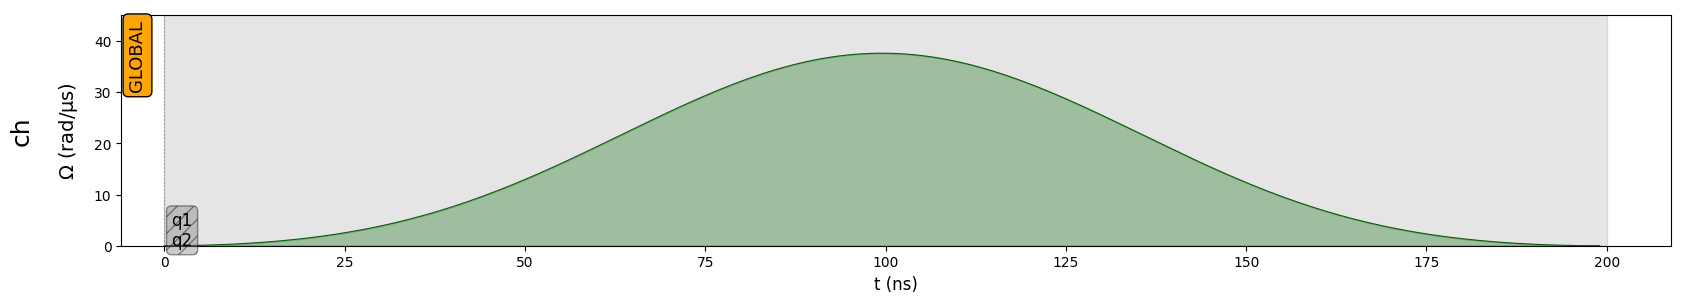

In [5]:
seq.draw()

The sequence drawing method also allows to visualize the register. If an SLM mask is defined, the masked qubits will appear with a shaded square halo around them:

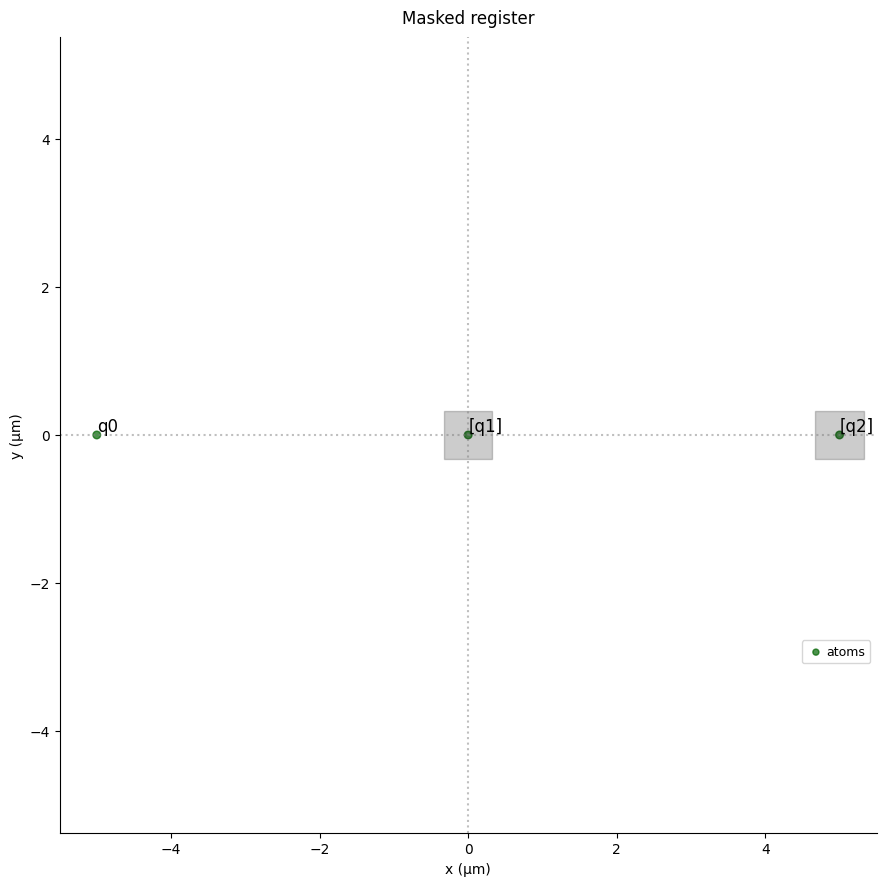

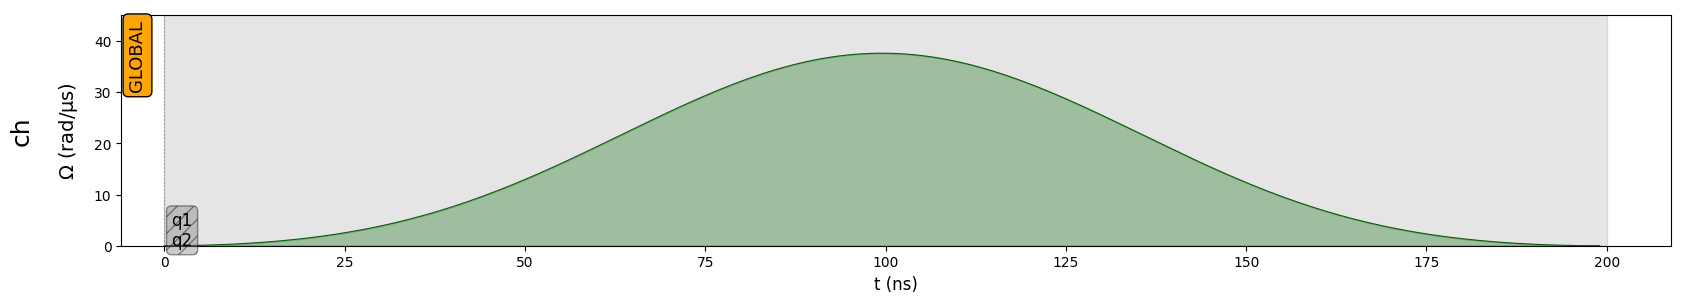

In [6]:
seq.draw(draw_register=True)

Now let's see how the system evolves under this masked pulse. Since the pulse only acts on the first qubit, we expect the final state to be $\left| 100 \right\rangle$, or, according to Pulser's conventions for XY basis states, $(0,1)^T \otimes (1,0)^T \otimes (1,0)^T$ in the Hilbert space $C^8$:

In [7]:
import qutip

qutip.tensor(qutip.basis(2, 1), qutip.basis(2, 0), qutip.basis(2, 0))

Quantum object: dims = [[2, 2, 2], [1, 1, 1]], shape = (8, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]]

Now run the simulation and print the final state as given by Pulser:

In [8]:
sim = QutipEmulator.from_sequence(seq)
results = sim.run()

results.get_final_state()

Quantum object: dims = [[2, 2, 2], [1, 1, 1]], shape = (8, 1), type = ket
Qobj data =
[[0.+0.00000000e+00j]
 [0.+0.00000000e+00j]
 [0.+0.00000000e+00j]
 [1.+0.00000000e+00j]
 [0.+0.00000000e+00j]
 [0.+0.00000000e+00j]
 [0.+0.00000000e+00j]
 [0.+1.05028623e-05j]]

As expected, the two states agree up to numerical errors.

### Notes on XY mode

Since the SLM mask is mostly useful for state preparation, its use in Pulser is restricted to the first pulse in the sequence. This can be seen by adding an extra pulse in the previous example and drawing the sequence:

In [9]:
seq.add(pulse, "ch")

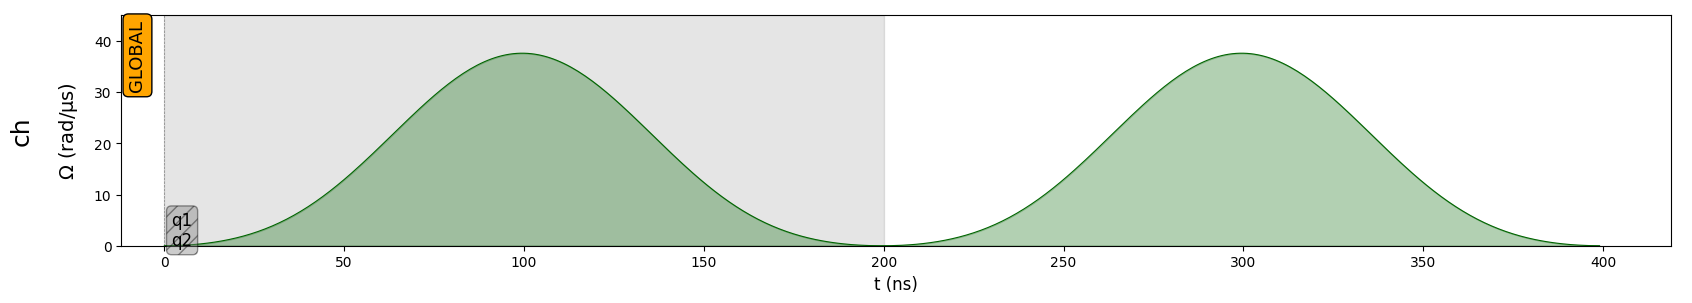

In [10]:
seq.draw()

This example also illustrates the fact that in XY mode, the SLM mask can be configured at any moment during the creation of a sequence (either before or after adding pulses) and it will automatically latch to the first pulse. <br>
However, in order to reflect real hardware constraints, the mask can be configured only once. Trying to configure the mask a second time will raise an error:

In [11]:
try:
    seq.config_slm_mask(masked_qubits)
except ValueError as err:
    print(err)

SLM mask can be configured only once.


## SLM Mask in Ising mode

In Ising mode, configuring an SLM Mask with a `DMM` labeled `dmm_id` in the device internally configures a detuning map using `config_detuning_map` (see notebook ["Local Addressability with DMM"](dmm.nblink) for an introduction) with `dmm_id` and a `DetuningMap` **distributing the applied detuning equally over all the masked qubits**.

For instance in the last example qubits "q1" and "q2" are masked, so we expect a `DetuningMap` associating to the trap location of "q0" the weight 0, and to the trap locations of "q1" and "q2" the weight $1/2 = 0.5$:

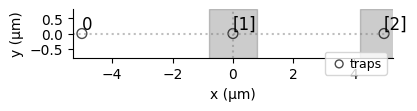

In [12]:
# Create the sequence
seq = Sequence(reg, MockDevice)

# Declare a global Rydberg channel and add the pi pulse
seq.declare_channel("ch", "rydberg_global")
pulse = Pulse.ConstantDetuning(BlackmanWaveform(200, np.pi), 0, 0)
seq.add(pulse, "ch")
# Mask the last two qubits
masked_qubits = ["q1", "q2"]
seq.config_slm_mask(masked_qubits, "dmm_0")
seq._schedule["dmm_0"].detuning_map.draw([0, 1, 2])

We can see that the shade of the square covering qubit 1 and 2 are the same, and that no square covers qubit 0: the detuning map created is exactly the one wanted.

Now what happens at the pulse level ?

If the SLM Mask is configured while some pulses had already been added to the sequence- as it is the case in the previous example- a pulse of constant detuning is immediately applied on the detuning map configured for the SLM Mask. The value of this detuning is very large compared to the amplitude of the first pulse in the schedule (ideally, -10 times this amplitude, or `bottom_detuning` of the `DMM` if `bottom_detunig` is defined and that the value is below it).  

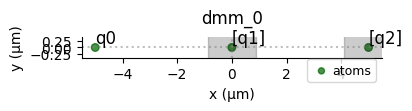

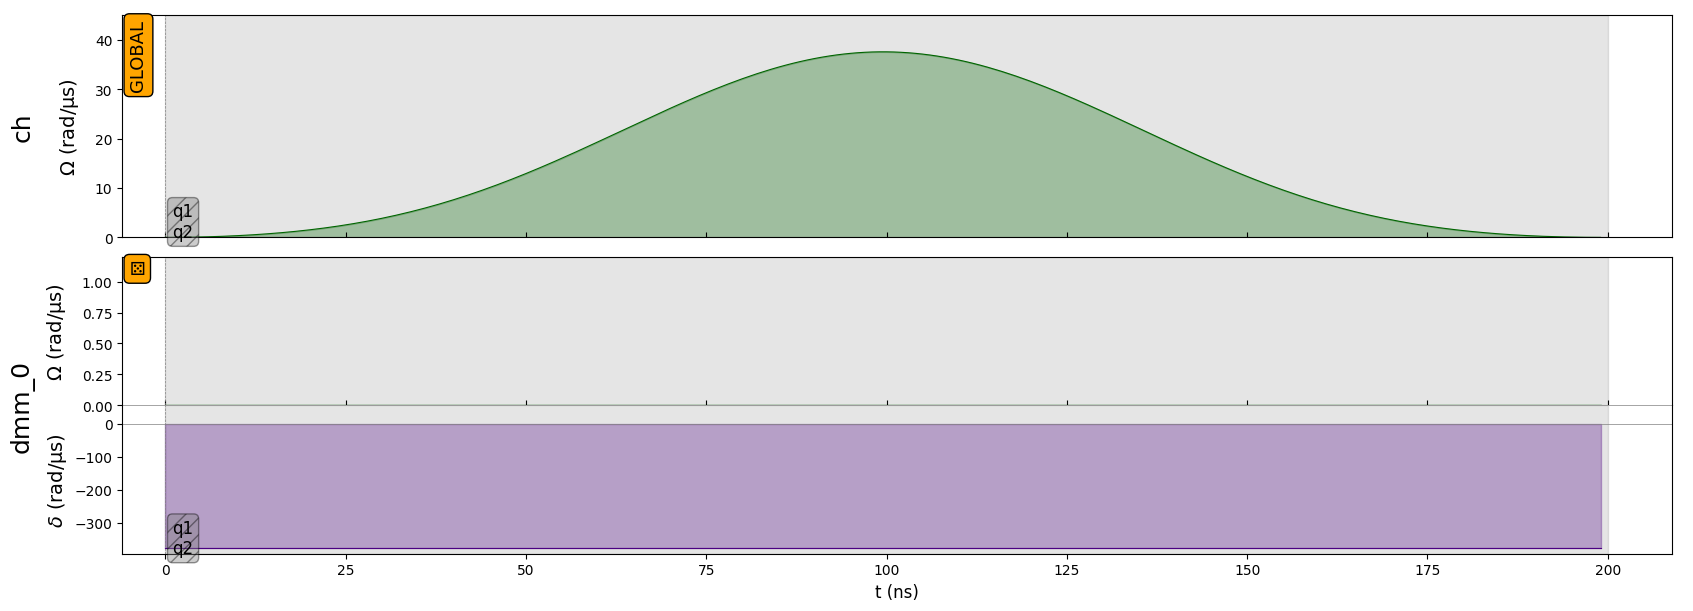

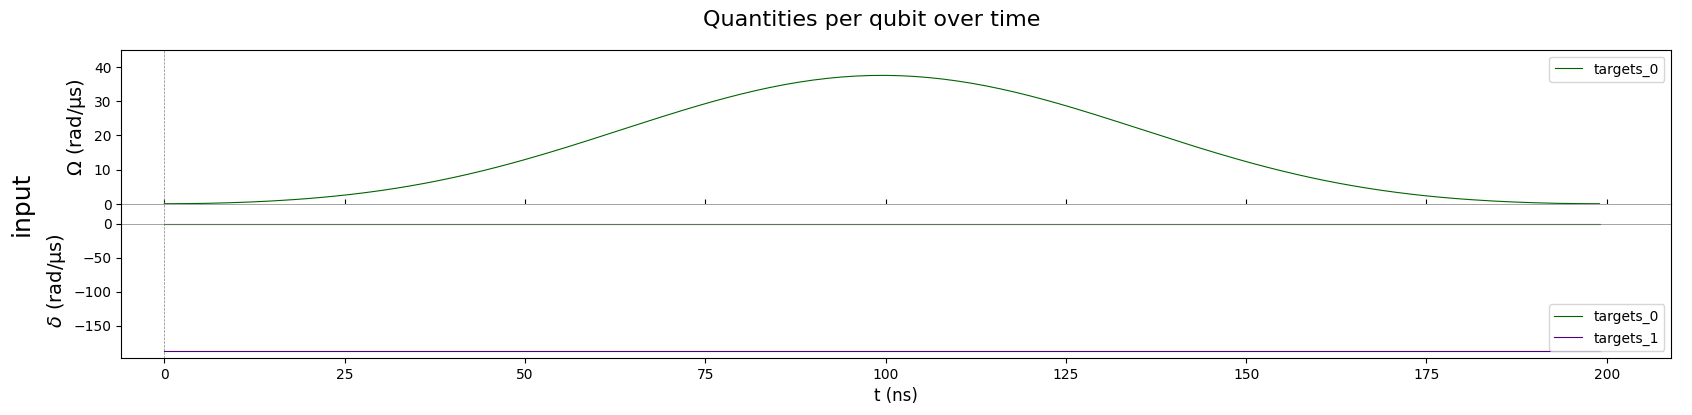

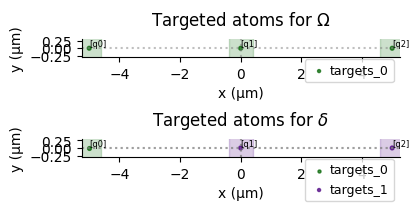

In [13]:
seq.draw(draw_detuning_maps=True, draw_qubit_amp=True, draw_qubit_det=True)

At the qubit level, you can see that all the qubits receive the $\sigma^x$ pulse of area $\pi$ in amplitude, but only qubit `q0` is on resonance (detuning is constant equal to 0) and will change state. Detuning on "q1" and "q2" being not of infinite values, they are not perfectly masked and therefore the state resulting from this sequence is not exactly the state $(1,0)^T \otimes (0,1)^T \otimes (0,1)^T$. However it is very close to this state and represents better the experiment.

In [14]:
sim = QutipEmulator.from_sequence(seq)
results = sim.run()

results.get_final_state()

Quantum object: dims = [[2, 2, 2], [1, 1, 1]], shape = (8, 1), type = ket
Qobj data =
[[ 1.05777889e-09+3.52313237e-10j]
 [ 1.94210895e-05-9.62160759e-06j]
 [ 7.73196609e-05+2.03526255e-04j]
 [ 9.99584287e-01+0.00000000e+00j]
 [-5.09040804e-09-5.54412670e-09j]
 [-4.52202551e-05-4.21374305e-04j]
 [ 2.19731223e-05-9.58138675e-06j]
 [-2.87837066e-02+1.58854957e-03j]]

<u>Note:</u> Of course, you can add pulses to channels or dmm after the SLM Mask:

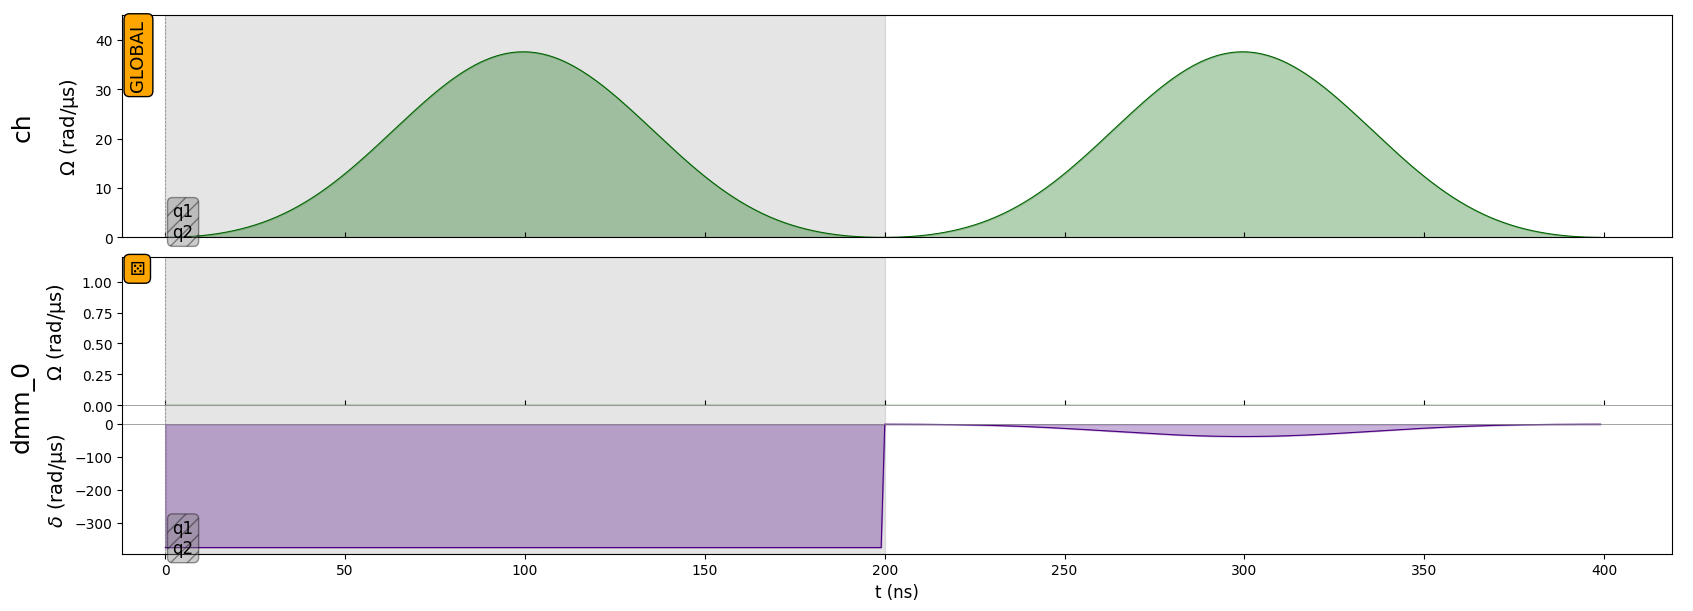

In [15]:
seq.add(pulse, "ch")
seq.add_dmm_detuning(-BlackmanWaveform(200, np.pi), "dmm_0")
seq.draw()

If the first operation performed in the sequence is the configuration of the SLM Mask, then the `DMM` used for the configuration of the SLM Mask cannot be used until a pulse is added on an Ising channel. The first pulse added will define the SLM Mask. 

In [17]:
# Create the sequence
seq = Sequence(reg, MockDevice)
# Mask the last two qubits
masked_qubits = ["q1", "q2"]
seq.config_slm_mask(masked_qubits, "dmm_0")
# Declare a global Rydberg channel and add the pi pulse
seq.declare_channel("ch", "rydberg_global")

try:
    seq.add_dmm_detuning(-BlackmanWaveform(200, np.pi), "dmm_0")
except ValueError as err:
    print(err)

You should add a Pulse to a Global Channel prior to modulating the DMM used for the SLM Mask.


In [ ]:
# Masked pulse
seq.add(pulse, "ch")
seq.draw()

### Note:
As in XY mode, you cannot configure the SLM Mask twice. However, be careful that in Ising mode, the moment you configure the SLM Mask matters: once configured, the masked pulse is never changed.